Folder frames, Video output, etc

> https://drive.google.com/drive/folders/1IEFym1hyzDxyYcG2oawekaXzraSMQjIC?usp=drive_link



# Setup Awal

In [ ]:
!pip install filterpy scipy openpyxl ultralytics -q

import os
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from google.colab import drive
import time
import gc

try:
    from filterpy.kalman import KalmanFilter
    from scipy.optimize import linear_sum_assignment
    print("filterpy dan scipy berhasil diimpor")
except ImportError:
    print("ERROR: Gagal mengimpor filterpy atau scipy.")
    KalmanFilter = None
    linear_sum_assignment = None

from google.colab.patches import cv2_imshow

try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    raise

BASE_PATH = '/content/drive/MyDrive/Final Project - CV/dataset'
if not os.path.exists(BASE_PATH):
    print(f"WARNING: BASE_PATH '{BASE_PATH}' tidak ada.")
else:
    print(f"BASE_PATH diatur ke {BASE_PATH}")

# Kalibrasi
LOCATION_DATA = {
    "Amplaz01": {
        "pts_src": np.float32([[1043.0, 23.0], [1504.0, 8.0], [548.0, 1339.0], [2118.0, 1331.0]]),
        "pts_dst": np.float32([[0.0, 0.0], [499.0, 0.0], [0.0, 699.0], [499.0, 699.0]]),
        "output_rect_wh": (500, 700),
        "pixels_per_meter": 44.5005
    },
    "Amplaz02": {
        "pts_src": np.float32([[779.0, 51.0], [1190.0, 59.0], [275.0, 1006.0], [1574.0, 1009.0]]),
        "pts_dst": np.float32([[0.0, 0.0], [499.0, 0.0], [0.0, 699.0], [499.0, 699.0]]),
        "output_rect_wh": (500, 700),
        "pixels_per_meter": 52.9554
    },
    "FKH01": {
        "pts_src": np.float32([[668.0, 209.0], [1281.0, 211.0], [174.0, 993.0], [1825.0, 980.0]]),
        "pts_dst": np.float32([[0.0, 0.0], [499.0, 0.0], [0.0, 699.0], [499.0, 699.0]]),
        "output_rect_wh": (500, 700),
        "pixels_per_meter": 31.0768
    },
    "FKH02": {
        "pts_src": np.float32([[440.0, 3.0], [802.0, 4.0], [70.0, 678.0], [1195.0, 642.0]]),
        "pts_dst": np.float32([[0.0, 0.0], [499.0, 0.0], [0.0, 699.0], [499.0, 699.0]]),
        "output_rect_wh": (500, 700),
        "pixels_per_meter": 39.7372
    }
}

# Model YOLO
try:
    yolo_model = YOLO('yolov8n.pt')
except Exception as e:
    print(f"Error memuat model YOLO: {e}")
    yolo_model = None

VIDEO_FPS = 30.0
IOU_THRESHOLD_SORT = 0.2
MIN_HITS_SORT = 3
MAX_AGE_SORT = 15
CENTROID_WEIGHT = 0.3

print(f"VIDEO_FPS: {VIDEO_FPS}")
print(f"Tracking Parameters - IoU: {IOU_THRESHOLD_SORT}, Min Hits: {MIN_HITS_SORT}, Max Age: {MAX_AGE_SORT}")

# Setting Visualisasi
SHOW_INTERMEDIATE_FRAMES = True
MAX_FRAMES_TO_SHOW = 1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
filterpy dan scipy berhasil diimpor
Mounted at /content/drive
BASE_PATH diatur ke /content/drive/MyDrive/Final Project - CV/dataset


100%|██████████| 6.25M/6.25M [00:00<00:00, 69.7MB/s]

VIDEO_FPS: 30.0
Tracking Parameters - IoU: 0.2, Min Hits: 3, Max Age: 15


# Fungsi Pengambilan Path


In [ ]:
def get_video_paths_from_folder_revised(location_folder_path, num_total_videos_per_folder=5,
                                       num_train_from_folder=4, video_extensions=('.mp4')):
    """Mengambil path video training dan testing dari folder lokasi"""
    if not os.path.isdir(location_folder_path):
        print(f"  [get_paths] Warning: Folder {location_folder_path} not found.")
        return [], []

    try:
        all_videos_in_folder = sorted([
            os.path.join(location_folder_path, f)
            for f in os.listdir(location_folder_path)
            if f.lower().endswith(video_extensions)
        ])
    except Exception as e:
        print(f"  [get_paths] Error list files: {e}")
        return [], []

    if len(all_videos_in_folder) != num_total_videos_per_folder:
        print(f"  [get_paths] Warning: Expected {num_total_videos_per_folder} videos, found {len(all_videos_in_folder)}")

    num_test_from_folder = num_total_videos_per_folder - num_train_from_folder
    training_videos = all_videos_in_folder[:num_train_from_folder]
    testing_videos = all_videos_in_folder[num_train_from_folder:num_train_from_folder + num_test_from_folder]

    return training_videos, testing_videos

def get_ground_truth_path_revised(location_folder_path, excel_extensions=('.xlsx', '.xls', '.csv')):
    if not os.path.isdir(location_folder_path):
        print(f"  [get_gt_path] Warning: Folder GT {location_folder_path} not found.")
        return None

    try:
        gt_files = [
            os.path.join(location_folder_path, f)
            for f in os.listdir(location_folder_path)
            if f.lower().endswith(excel_extensions)
        ]
    except Exception as e:
        print(f"  [get_gt_path] Error list GT files: {e}")
        return None

    if gt_files:
        if len(gt_files) > 1:
            # Cari file yang paling relevan
            specific_gt_files = [
                f for f in gt_files
                if (os.path.basename(f).lower().startswith(os.path.basename(location_folder_path).lower())
                    or 'groundtruth' in f.lower() or 'gt' in f.lower())
            ]
            if specific_gt_files:
                print(f"  [get_gt_path] Using specific file: {os.path.basename(specific_gt_files[0])}")
                return specific_gt_files[0]
            print(f"  [get_gt_path] Multiple files found, using: {os.path.basename(gt_files[0])}")
        return gt_files[0]

    print(f"  [get_gt_path] Warning: No Excel/CSV file found in {location_folder_path}")
    return None

# Fungsi Preprocessing
Convert ke numpy dan DLT

In [ ]:
def sample_frames_from_video(video_path, sample_rate=1):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"    [sample_frames] Error: Cannot open video {video_path}")
        return [], VIDEO_FPS, 0

    sampled_frames_list = []
    frame_idx = 0
    original_video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if original_video_fps == 0 or original_video_fps is None:
        original_video_fps = VIDEO_FPS

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        sampled_frames_list.append(frame)
        frame_idx += 1

    cap.release()
    print(f"    [sample_frames] Video: {os.path.basename(video_path)}")
    print(f"      FPS: {original_video_fps:.2f}, Total: {total_frames_in_video}, Sampled: {len(sampled_frames_list)}")

    return sampled_frames_list, original_video_fps, total_frames_in_video

def get_perspective_transform_details(video_path_str, loc_data_dict):
    try:
        location_name_from_path = os.path.basename(os.path.dirname(video_path_str))
    except Exception as e:
        print(f"    [get_perspective] Error extract location name: {e}")
        return None, (0,0), None

    if location_name_from_path not in loc_data_dict:
        print(f"    [get_perspective] Error: Location '{location_name_from_path}' not in LOCATION_DATA")
        return None, (0,0), location_name_from_path

    data = loc_data_dict[location_name_from_path]
    transform_matrix = cv2.getPerspectiveTransform(data["pts_src"], data["pts_dst"])

    return transform_matrix, data["output_rect_wh"], location_name_from_path

def apply_perspective_to_frame(input_frame, p_matrix, out_wh):
    if p_matrix is None or not isinstance(input_frame, np.ndarray) or input_frame.size == 0:
        return None
    return cv2.warpPerspective(input_frame, p_matrix, out_wh)

# Fungsi Kalman

In [ ]:
def initialize_kalman_filter_improved():
    if KalmanFilter is None:
        print("    [kalman_init] Error: filterpy.KalmanFilter tidak terimport")
        return None

    # State: [x, y, vx, vy]
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.x = np.zeros(4)

    # Transition matrix
    dt = 1.0
    kf.F = np.array([[1, 0, dt, 0 ],
                     [0, 1, 0,  dt],
                     [0, 0, 1,  0 ],
                     [0, 0, 0,  1 ]])

    # Measurement matrix
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0]])

    # Covariance matrices
    kf.P *= 100.
    kf.R = np.diag([10, 10])
    kf.Q = np.diag([1, 1, 5, 5])

    return kf

def calculate_combined_distance(tracker, detection):

    # IoU component
    def calculate_iou(bbox1, bbox2):
        x1i = max(bbox1[0], bbox2[0])
        y1i = max(bbox1[1], bbox2[1])
        x2i = min(bbox1[2], bbox2[2])
        y2i = min(bbox1[3], bbox2[3])

        if x2i <= x1i or y2i <= y1i:
            return 0.0

        intersection_area = (x2i - x1i) * (y2i - y1i)
        area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
        union_area = area1 + area2 - intersection_area

        return intersection_area / union_area if union_area > 0 else 0.0

    iou_score = calculate_iou(tracker['bbox'], detection['bbox'])

    # Centroid distance component
    if tracker['centroid_history']:
        tx, ty = tracker['centroid_history'][-1]
        dx, dy = detection['centroid']
        centroid_dist = np.sqrt((tx - dx)**2 + (ty - dy)**2)

        # Normalize (
        normalized_centroid_dist = min(centroid_dist / 100.0, 1.0)
        centroid_score = 1.0 - normalized_centroid_dist
    else:
        centroid_score = 0.0

    # Combined score
    combined_score = (1.0 - CENTROID_WEIGHT) * iou_score + CENTROID_WEIGHT * centroid_score

    return combined_score

def calculate_smooth_speed(tracker, current_pixels_per_meter, current_fps_video, smoothing_frames=3):
    if len(tracker['centroid_history']) < max(2, smoothing_frames):
        return -1.0
    recent_points = tracker['centroid_history'][-smoothing_frames:]
    total_distance = 0
    num_steps = len(recent_points) - 1

    for i in range(num_steps):
        p1 = recent_points[i]
        p2 = recent_points[i + 1]
        distance_px = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
        total_distance += distance_px

    if num_steps == 0:
        return -1.0

    avg_distance_px_per_frame = total_distance / num_steps
    distance_m_per_frame = avg_distance_px_per_frame / current_pixels_per_meter

    delta_t = 1.0 / current_fps_video if current_fps_video > 0 else float('inf')
    if delta_t == float('inf') or delta_t <= 0:
        return -1.0

    speed_mps = distance_m_per_frame / delta_t
    speed_kmh = round(speed_mps * 3.6, 1)

    return speed_kmh

def improved_tracking_step(active_trackers, current_frame_detections, next_tracker_id):
    # Prediksi trackers
    for tracker in active_trackers:
        if tracker['kf'] is not None:
            tracker['kf'].predict()

    num_trackers = len(active_trackers)
    num_detections = len(current_frame_detections)

    # Membuat cost matrix
    if num_trackers > 0 and num_detections > 0:
        cost_matrix = np.zeros((num_trackers, num_detections))

        for t_idx, tracker in enumerate(active_trackers):
            for d_idx, detection in enumerate(current_frame_detections):
                similarity = calculate_combined_distance(tracker, detection)
                cost_matrix[t_idx, d_idx] = 1.0 - similarity  # Convert to cost

        # Hungarian algorithm matching
        if linear_sum_assignment is not None:
            row_indices, col_indices = linear_sum_assignment(cost_matrix)
            matched_indices = []

            for r_i, c_i in zip(row_indices, col_indices):
                if cost_matrix[r_i, c_i] < (1.0 - IOU_THRESHOLD_SORT):
                    matched_indices.append((r_i, c_i))
        else:
            matched_indices = []
    else:
        matched_indices = []

    # Track matched and unmatched
    unmatched_trackers = [True] * num_trackers
    unmatched_detections = [True] * num_detections

    # Update matched trackers
    for t_idx, d_idx in matched_indices:
        tracker = active_trackers[t_idx]
        detection = current_frame_detections[d_idx]

        # Update Kalman filter
        if tracker['kf'] is not None:
            tracker['kf'].update(np.array(detection['centroid']))

        # Update tracker state
        tracker.update({
            'bbox': detection['bbox'],
            'centroid_history': tracker['centroid_history'] + [detection['centroid']],
            'hits': tracker['hits'] + 1,
            'time_since_update': 0
        })

        unmatched_trackers[t_idx] = False
        unmatched_detections[d_idx] = False

    # Remove old trackers
    updated_trackers = []
    for t_idx, tracker in enumerate(active_trackers):
        tracker['age'] += 1

        if unmatched_trackers[t_idx]:
            tracker['time_since_update'] += 1

        # Improved removal criteria
        should_keep = not (
            tracker['time_since_update'] > MAX_AGE_SORT or
            (tracker['hits'] < MIN_HITS_SORT and tracker['age'] > (MIN_HITS_SORT + MAX_AGE_SORT // 2))
        )

        if should_keep:
            updated_trackers.append(tracker)

    active_trackers = updated_trackers

    # Create new trackers for unmatched detections
    for d_idx in range(num_detections):
        if unmatched_detections[d_idx]:
            detection = current_frame_detections[d_idx]
            kf = initialize_kalman_filter_improved()

            if kf is not None:
                kf.x[0], kf.x[1] = detection['centroid'][0], detection['centroid'][1]

                new_tracker = {
                    'id': next_tracker_id,
                    'kf': kf,
                    'bbox': detection['bbox'],
                    'centroid_history': [detection['centroid']],
                    'age': 1,
                    'hits': 1,
                    'time_since_update': 0
                }

                active_trackers.append(new_tracker)
                next_tracker_id += 1

    return active_trackers, next_tracker_id

# Fungsi Evaluasi

In [ ]:
ACTUAL_COLUMN_FRAME_GT = 'Index'
ACTUAL_COLUMN_SPEED_GT = 'Ground Truth'
ACTUAL_COLUMN_DIRECTION_GT = 'L/R'

def load_ground_truth_confirmed(excel_path, sheet_name=0):
    """Load dan validasi file ground truth"""
    try:
        if str(excel_path).lower().endswith('.csv'):
            df_gt = pd.read_csv(excel_path)
        else:
            df_gt = pd.read_excel(excel_path, sheet_name=sheet_name, engine='openpyxl')

        print(f"    [load_gt] Loaded from {os.path.basename(str(excel_path))}")
        print(f"      Original columns: {df_gt.columns.tolist()}")

        required_cols = [ACTUAL_COLUMN_FRAME_GT, ACTUAL_COLUMN_SPEED_GT]
        for col in required_cols:
            if col not in df_gt.columns:
                print(f"    [load_gt] Error: Column '{col}' not found")
                return None

        rename_map = {
            ACTUAL_COLUMN_FRAME_GT: 'Frame_GT_Standard',
            ACTUAL_COLUMN_SPEED_GT: 'Speed_GT_Standard'
        }
        if ACTUAL_COLUMN_DIRECTION_GT in df_gt.columns:
            rename_map[ACTUAL_COLUMN_DIRECTION_GT] = 'Direction_GT_Standard'

        df_gt = df_gt.rename(columns=rename_map)

        if df_gt['Frame_GT_Standard'].isnull().any() or df_gt['Speed_GT_Standard'].isnull().any():
            print("    [load_gt] Warning: NaN values found in Frame/Speed GT")

        df_gt['Frame_GT_Standard'] = df_gt['Frame_GT_Standard'].astype(int)

        return df_gt

    except FileNotFoundError:
        print(f"    [load_gt] Error: File not found {excel_path}")
        return None
    except Exception as e:
        print(f"    [load_gt] Error: {e}")
        return None

def match_estimations_to_gt_simplified(estimations_list, gt_dataframe):
    matched_pairs = []
    gt_map = {}
    used_estimation_frames = set()

    if not estimations_list or gt_dataframe.empty:
        print("    [match] Empty estimation or GT data")
        return []

    # Create GT mapping
    for frame_val, speed_val in zip(gt_dataframe['Frame_GT_Standard'], gt_dataframe['Speed_GT_Standard']):
        if frame_val not in gt_map:
            gt_map[frame_val] = []
        gt_map[frame_val].append(speed_val)

    # Match estimations to GT
    for estimation in estimations_list:
        est_frame = estimation['frame_idx']
        est_speed = estimation['speed_kmh']

        if est_frame not in used_estimation_frames and est_frame in gt_map:
            if gt_map[est_frame]:
                gt_speed = gt_map[est_frame][0]
                matched_pairs.append({
                    'est_speed': est_speed,
                    'gt_speed': gt_speed,
                    'frame': est_frame
                })
                used_estimation_frames.add(est_frame)

    print(f"    [match] Found {len(matched_pairs)} matched pairs")
    return matched_pairs

def calculate_speed_evaluation_metrics(matched_data_list):
    if not matched_data_list:
        return float('nan'), float('nan'), float('nan')

    errors = []
    squared_errors = []
    gt_speeds_for_mape = []
    est_speeds_for_mape = []

    for pair in matched_data_list:
        try:
            est_speed = float(pair['est_speed'])
            gt_speed = float(pair['gt_speed'])
        except (ValueError, TypeError):
            print(f"    [eval] Warning: Skip pair due to conversion error: {pair}")
            continue

        if gt_speed > 0:
            gt_speeds_for_mape.append(gt_speed)
            est_speeds_for_mape.append(est_speed)

        error = est_speed - gt_speed
        errors.append(abs(error))
        squared_errors.append(error**2)

    # Calculate metrics
    mae = np.mean(errors) if errors else float('nan')
    rmse = np.sqrt(np.mean(squared_errors)) if squared_errors else float('nan')
    mape = float('nan')

    if gt_speeds_for_mape:
        np_gt_speeds = np.array(gt_speeds_for_mape)
        if np.all(np_gt_speeds > 0):
            mape = np.mean(np.abs((np.array(est_speeds_for_mape) - np_gt_speeds) / np_gt_speeds)) * 100

    print(f"    --- Evaluation Metrics ({len(matched_data_list)} pairs) ---")
    print(f"    MAE: {mae:.2f} km/h")
    print(f"    RMSE: {rmse:.2f} km/h")
    if not np.isnan(mape):
        print(f"    MAPE: {mape:.2f}%")
    else:
        print("    MAPE: N/A")

    return mae, rmse, mape

# Proses Pengumpulan Path Video dan Ground Truth

In [ ]:
all_training_video_paths = []
all_testing_video_paths = []
ground_truth_file_paths = {}

if 'LOCATION_DATA' not in globals() or 'BASE_PATH' not in globals():
    print("Error: LOCATION_DATA or BASE_PATH not defined.")
else:
    for loc_name in LOCATION_DATA.keys():
        loc_folder = os.path.join(BASE_PATH, loc_name)
        print(f"\nProcessing location: {loc_name}")
        print(f"  Folder path: {loc_folder}")

        if os.path.isdir(loc_folder):
            train_videos, test_videos = get_video_paths_from_folder_revised(
                loc_folder,
                num_total_videos_per_folder=5,
                num_train_from_folder=4
            )

            all_training_video_paths.extend(train_videos)
            all_testing_video_paths.extend(test_videos)
            print(f"Found {len(train_videos)} training, {len(test_videos)} testing videos")

            gt_path = get_ground_truth_path_revised(loc_folder)
            if gt_path:
                ground_truth_file_paths[loc_name] = gt_path
                print(f"Found GT file: {os.path.basename(str(gt_path))}")
            else:
                print(f"No GT file found for {loc_name}")
        else:
            print(f"Location folder not found: {loc_folder}")

    print(f"Total training videos: {len(all_training_video_paths)}")
    print(f"Total testing videos: {len(all_testing_video_paths)}")
    print(f"Total GT files: {len(ground_truth_file_paths)}")

    if len(all_testing_video_paths) == 4 and len(ground_truth_file_paths) == 4:
        print("Expected counts match (4 testing videos, 4 GT files)")
    else:
        print("Counts don't match expected values")


Processing location: Amplaz01
  Folder path: /content/drive/MyDrive/Final Project - CV/dataset/Amplaz01
Found 4 training, 1 testing videos
Found GT file: Amplaz01a.xlsx

Processing location: Amplaz02
  Folder path: /content/drive/MyDrive/Final Project - CV/dataset/Amplaz02
Found 4 training, 1 testing videos
Found GT file: Amplaz02a.xlsx

Processing location: FKH01
  Folder path: /content/drive/MyDrive/Final Project - CV/dataset/FKH01
Found 4 training, 1 testing videos
Found GT file: FKH01a.xlsx

Processing location: FKH02
  Folder path: /content/drive/MyDrive/Final Project - CV/dataset/FKH02
Found 4 training, 1 testing videos
Found GT file: FKH02a.xlsx
Total training videos: 16
Total testing videos: 4
Total GT files: 4
Expected counts match (4 testing videos, 4 GT files)


# Pemrosesan Video Testing

Semua prasyarat terpenuhi. Memulai pemrosesan video testing...


MEMPROSES VIDEO TESTING 1/4: 5.mp4
Lokasi terdeteksi: Amplaz01
    [sample_frames] Video: 5.mp4
      FPS: 30.00, Total: 1801, Sampled: 1801
Menampilkan contoh frame asli pertama (index 0) untuk 5.mp4:


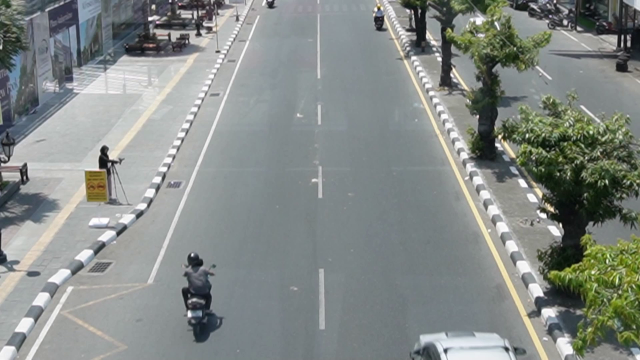

Selesai preprocessing. 1801 frame Bird's-Eye View (BEV) siap.
Menampilkan contoh frame BEV pertama (index 0) untuk 5.mp4:


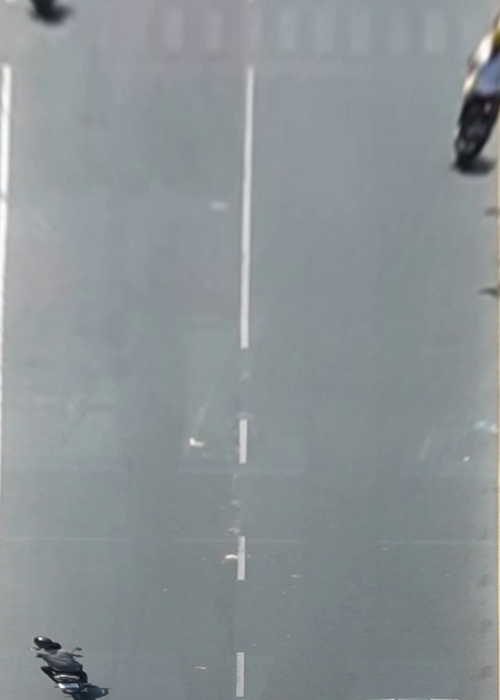

Output video visual disimpan ke: /content/output_visual_Amplaz01_5.mp4
Memproses frame BEV ke-200/1801...
Memproses frame BEV ke-400/1801...
Memproses frame BEV ke-600/1801...
Memproses frame BEV ke-800/1801...
Memproses frame BEV ke-1000/1801...
Memproses frame BEV ke-1200/1801...
Memproses frame BEV ke-1400/1801...
Memproses frame BEV ke-1600/1801...
Memproses frame BEV ke-1800/1801...
Video disimpan di /content/output_visual_Amplaz01_5.mp4
Total data estimasi terkumpul: 4192

  --- Tahap 7: Evaluasi untuk Amplaz01 ---
    [load_gt] Loaded from Amplaz01a.xlsx
      Original columns: ['Index', 'Ground Truth']
    [match] Found 17 matched pairs
    --- Evaluation Metrics (17 pairs) ---
    MAE: 13.47 km/h
    RMSE: 20.20 km/h
    MAPE: 55.44%


MEMPROSES VIDEO TESTING 2/4: 5.mp4
Lokasi terdeteksi: Amplaz02
    [sample_frames] Video: 5.mp4
      FPS: 30.00, Total: 1800, Sampled: 1800
Menampilkan contoh frame asli pertama (index 0) untuk 5.mp4:


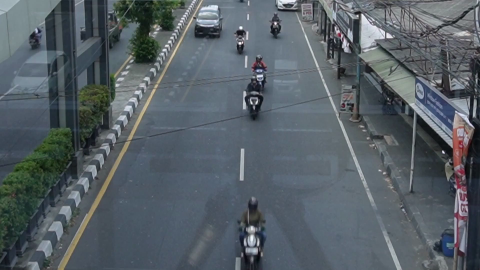

Selesai preprocessing. 1800 frame Bird's-Eye View (BEV) siap.
Menampilkan contoh frame BEV pertama (index 0) untuk 5.mp4:


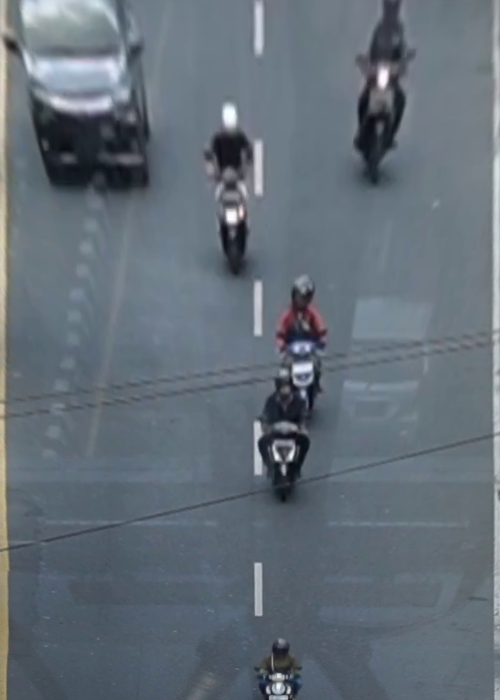

Output video visual disimpan ke: /content/output_visual_Amplaz02_5.mp4
Contoh deteksi YOLO pada frame BEV ke-1 untuk 5.mp4:


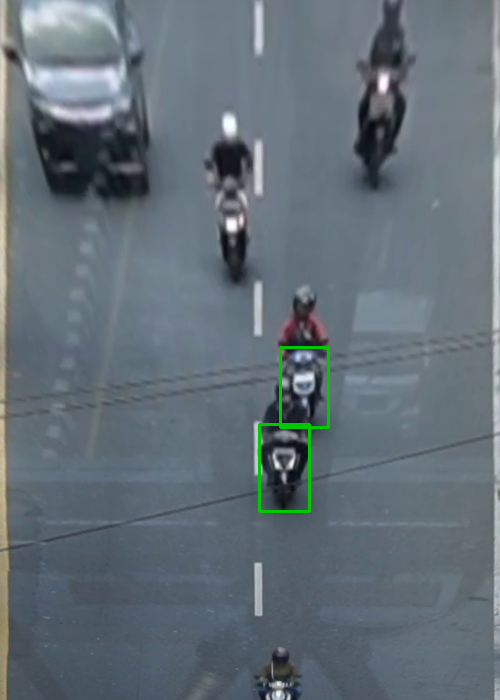

Memproses frame BEV ke-200/1800...
Memproses frame BEV ke-400/1800...
Memproses frame BEV ke-600/1800...
Memproses frame BEV ke-800/1800...
Memproses frame BEV ke-1000/1800...
Memproses frame BEV ke-1200/1800...
Memproses frame BEV ke-1400/1800...
Memproses frame BEV ke-1600/1800...
Memproses frame BEV ke-1800/1800...
Video disimpan di /content/output_visual_Amplaz02_5.mp4
Total data estimasi terkumpul: 5448

  --- Tahap 7: Evaluasi untuk Amplaz02 ---
    [load_gt] Loaded from Amplaz02a.xlsx
      Original columns: ['Index', 'Ground Truth']
    [match] Found 55 matched pairs
    --- Evaluation Metrics (55 pairs) ---
    MAE: 22.96 km/h
    RMSE: 24.96 km/h
    MAPE: 60.52%


MEMPROSES VIDEO TESTING 3/4: 5.mp4
Lokasi terdeteksi: FKH01
    [sample_frames] Video: 5.mp4
      FPS: 30.00, Total: 1801, Sampled: 1801
Menampilkan contoh frame asli pertama (index 0) untuk 5.mp4:


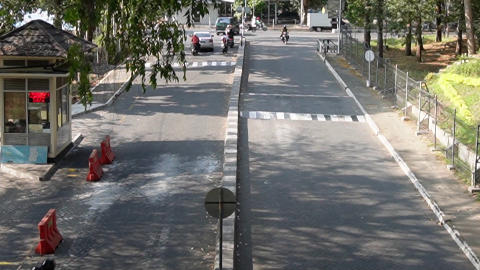

Selesai preprocessing. 1801 frame Bird's-Eye View (BEV) siap.
Menampilkan contoh frame BEV pertama (index 0) untuk 5.mp4:


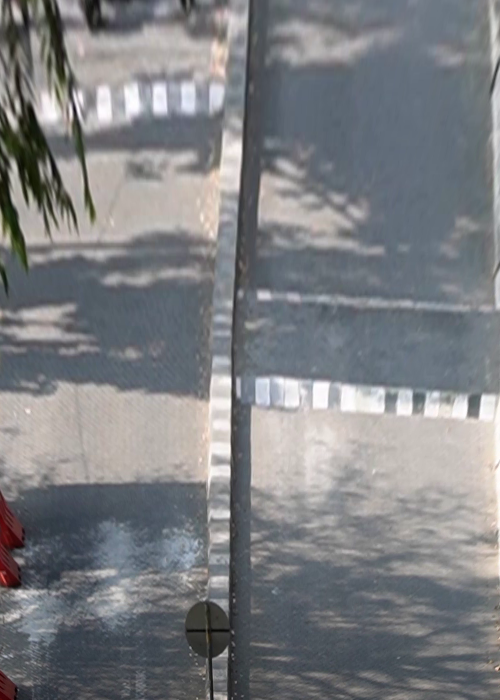

Output video visual disimpan ke: /content/output_visual_FKH01_5.mp4
Memproses frame BEV ke-200/1801...
Memproses frame BEV ke-400/1801...
Memproses frame BEV ke-600/1801...
Memproses frame BEV ke-800/1801...
Memproses frame BEV ke-1000/1801...
Memproses frame BEV ke-1200/1801...
Memproses frame BEV ke-1400/1801...
Memproses frame BEV ke-1600/1801...
Memproses frame BEV ke-1800/1801...
Video disimpan di /content/output_visual_FKH01_5.mp4
Total data estimasi terkumpul: 647

  --- Tahap 7: Evaluasi untuk FKH01 ---
    [load_gt] Loaded from FKH01a.xlsx
      Original columns: ['Index', 'L/R', 'Ground Truth']
    [match] Found 7 matched pairs
    --- Evaluation Metrics (7 pairs) ---
    MAE: 13.64 km/h
    RMSE: 15.69 km/h
    MAPE: 56.69%


MEMPROSES VIDEO TESTING 4/4: 5.mp4
Lokasi terdeteksi: FKH02
    [sample_frames] Video: 5.mp4
      FPS: 30.00, Total: 1788, Sampled: 1788
Menampilkan contoh frame asli pertama (index 0) untuk 5.mp4:


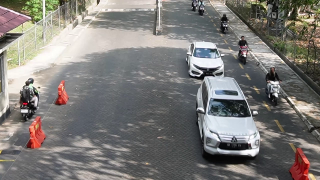

Selesai preprocessing. 1788 frame Bird's-Eye View (BEV) siap.
Menampilkan contoh frame BEV pertama (index 0) untuk 5.mp4:


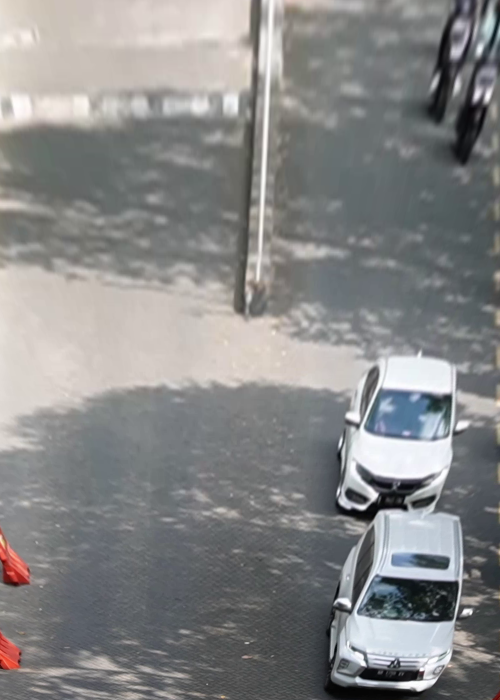

Output video visual disimpan ke: /content/output_visual_FKH02_5.mp4
Contoh deteksi YOLO pada frame BEV ke-1 untuk 5.mp4:


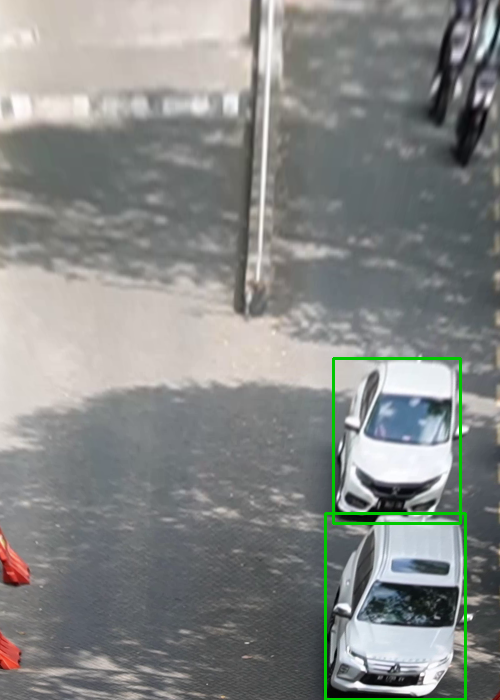

Memproses frame BEV ke-200/1788...
Memproses frame BEV ke-400/1788...
Memproses frame BEV ke-600/1788...
Memproses frame BEV ke-800/1788...
Memproses frame BEV ke-1000/1788...
Memproses frame BEV ke-1200/1788...
Memproses frame BEV ke-1400/1788...
Memproses frame BEV ke-1600/1788...
Video disimpan di /content/output_visual_FKH02_5.mp4
Total data estimasi terkumpul: 1484

  --- Tahap 7: Evaluasi untuk FKH02 ---
    [load_gt] Loaded from FKH02a.xlsx
      Original columns: ['Index', 'L/R', 'Ground Truth']
    [match] Found 8 matched pairs
    --- Evaluation Metrics (8 pairs) ---
    MAE: 10.30 km/h
    RMSE: 11.53 km/h
    MAPE: 50.94%


In [ ]:
all_location_metrics = {}

if 'all_testing_video_paths' not in globals() or not all_testing_video_paths:
    print("Error: 'all_testing_video_paths' tidak ada.")
elif 'yolo_model' not in globals() or yolo_model is None:
    print("Error: 'yolo_model' tidak termuat.")
elif 'KalmanFilter' not in globals() or KalmanFilter is None or \
     'linear_sum_assignment' not in globals() or linear_sum_assignment is None:
    print("Error: Library 'filterpy' atau 'scipy' belum terimport dengan benar.")
else:
    print("Semua prasyarat terpenuhi. Memulai pemrosesan video testing...")

    for video_idx, video_test_path in enumerate(all_testing_video_paths):
        print(f"\n\n{'='*70}\nMEMPROSES VIDEO TESTING {video_idx+1}/{len(all_testing_video_paths)}: {os.path.basename(video_test_path)}\n{'='*70}")

        extracted_loc_name = os.path.basename(os.path.dirname(video_test_path))
        if extracted_loc_name not in LOCATION_DATA:
            print(f"Error: Lokasi '{extracted_loc_name}' dari path '{video_test_path}' tidak dikenal di LOCATION_DATA."); continue
        print(f"Lokasi terdeteksi: {extracted_loc_name}")

        current_pixels_per_meter = LOCATION_DATA[extracted_loc_name]["pixels_per_meter"]
        processed_frames_for_yolo_current = []
        current_fps_video = VIDEO_FPS
        final_tracked_vehicle_data_current = []

        next_tracker_id_loop = 0
        active_trackers_loop = []
        last_known_speed_per_id_loop = {}

        if not os.path.exists(video_test_path):
            print(f"Error: File video {video_test_path} tidak ditemukan."); continue

        list_of_sampled_frames, fps_from_func, total_original_frames = sample_frames_from_video(video_test_path, sample_rate=1)
        if fps_from_func > 0: current_fps_video = fps_from_func

        if not list_of_sampled_frames:
            print(f"Error: Tidak ada frame yang diambil dari {video_test_path}."); continue

        if SHOW_INTERMEDIATE_FRAMES and list_of_sampled_frames:
            print(f"Menampilkan contoh frame asli pertama (index 0) untuk {os.path.basename(video_test_path)}:")
            try:
                display_frame_original = cv2.resize(list_of_sampled_frames[0], (0,0), fx=0.25, fy=0.25)
                cv2_imshow(display_frame_original)
            except Exception as e_vis:
                print(f"Gagal menampilkan frame asli {e_vis}")

        M_perspective, output_dimensions, _ = get_perspective_transform_details(video_test_path, LOCATION_DATA)
        if M_perspective is None or output_dimensions[0] == 0:
            print(f"Error: Gagal mendapatkan matriks/dimensi transformasi untuk DLT."); continue

        for s_idx, single_frame in enumerate(list_of_sampled_frames):
            transformed_frame = apply_perspective_to_frame(single_frame, M_perspective, output_dimensions) # Fungsi dari Blok 1
            if transformed_frame is not None:
                processed_frames_for_yolo_current.append(transformed_frame)
            else:
                print(f"Frame {s_idx} gagal ditransformasi DLT.")

        del list_of_sampled_frames # Hemat memori
        gc.collect()

        if not processed_frames_for_yolo_current:
            print(f"Error: Tidak ada frame yang berhasil ditransformasi DLT."); continue
        print(f"Selesai preprocessing. {len(processed_frames_for_yolo_current)} frame Bird's-Eye View (BEV) siap.")

        if SHOW_INTERMEDIATE_FRAMES and processed_frames_for_yolo_current:
            print(f"Menampilkan contoh frame BEV pertama (index 0) untuk {os.path.basename(video_test_path)}:")
            try:
                cv2_imshow(processed_frames_for_yolo_current[0])
            except Exception as e_vis:
                print(f"Gagal menampilkan frame BEV contoh - {e_vis}")

        output_video_fname = f"output_visual_{extracted_loc_name}_{os.path.basename(video_test_path).split('.')[0]}.mp4"
        output_video_fpath = os.path.join("/content/", output_video_fname) # Simpan di root Colab sementara
        video_writer = None

        frame_h_bev, frame_w_bev, _ = processed_frames_for_yolo_current[0].shape
        if current_fps_video > 0 and frame_w_bev > 0 and frame_h_bev > 0:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_writer = cv2.VideoWriter(output_video_fpath, fourcc, current_fps_video, (frame_w_bev, frame_h_bev))
            print(f"Output video visual disimpan ke: {output_video_fpath}")
        else:
            print(f"FPS ({current_fps_video}) atau dimensi ({frame_w_bev}x{frame_h_bev}) tidak valid.")

        for frame_idx_main, bev_frame_original in enumerate(processed_frames_for_yolo_current):
            if (frame_idx_main + 1) % 200 == 0:
                print(f"Memproses frame BEV ke-{frame_idx_main + 1}/{len(processed_frames_for_yolo_current)}...")

            bev_frame_to_draw = bev_frame_original.copy()

            vehicle_cls_ids = [2, 3, 5, 7]
            yolo_raw_dets = yolo_model.predict(bev_frame_to_draw, classes=vehicle_cls_ids, verbose=False)

            current_frame_detections = []
            if yolo_raw_dets and len(yolo_raw_dets) > 0 and yolo_raw_dets[0].boxes:
                for box in yolo_raw_dets[0].boxes:
                    x1,y1,x2,y2 = map(int,box.xyxy[0])
                    cx,cy = int((x1+x2)/2), int((y1+y2)/2)
                    current_frame_detections.append({'bbox':[x1,y1,x2,y2],'centroid':(cx,cy)})

            if SHOW_INTERMEDIATE_FRAMES and frame_idx_main == MAX_FRAMES_TO_SHOW and current_frame_detections:
                print(f"Contoh deteksi YOLO pada frame BEV ke-{frame_idx_main} untuk {os.path.basename(video_test_path)}:")
                temp_yolo_vis_frame = bev_frame_original.copy()
                for det_yolo in current_frame_detections:
                    x1d,y1d,x2d,y2d = det_yolo['bbox']
                    cv2.rectangle(temp_yolo_vis_frame,(x1d,y1d),(x2d,y2d),(0,200,0),2)
                try:
                    cv2_imshow(temp_yolo_vis_frame)
                except Exception as e_vis:
                    print(f"Gagal menampilkan frame deteksi YOLO {e_vis}")

            active_trackers_loop, next_tracker_id_loop = improved_tracking_step(
                active_trackers_loop,
                current_frame_detections,
                next_tracker_id_loop
            )

            for tracker_obj in active_trackers_loop:
                if tracker_obj['hits'] >= MIN_HITS_SORT and tracker_obj['time_since_update'] == 0:
                    current_speed_kmh = calculate_smooth_speed(
                        tracker_obj,
                        current_pixels_per_meter,
                        current_fps_video,
                        smoothing_frames=3
                    )

                    if current_speed_kmh != -1.0:
                        last_known_speed_per_id_loop[tracker_obj['id']] = current_speed_kmh
                        final_tracked_vehicle_data_current.append({
                            'id': tracker_obj['id'],
                            'frame_idx': frame_idx_main,
                            'speed_kmh': current_speed_kmh,
                            'bbox_bird_eye': tracker_obj['bbox'],
                            'centroid_bird_eye': tracker_obj['centroid_history'][-1]
                        })

                    #Bounding box tracker
                    x1t, y1t, x2t, y2t = tracker_obj['bbox']
                    cv2.rectangle(bev_frame_to_draw, (x1t, y1t), (x2t, y2t), (255, 0, 0), 2)

                    display_speed = last_known_speed_per_id_loop.get(tracker_obj['id'], None)
                    info_text = f"ID:{tracker_obj['id']}"
                    if display_speed is not None:
                        info_text += f" {display_speed:.1f}km/h"

                    cv2.putText(bev_frame_to_draw, info_text,
                                (x1t, y1t - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 1)

            if video_writer:
                video_writer.write(bev_frame_to_draw)

        if video_writer:
            video_writer.release()
            print(f"Video disimpan di {output_video_fpath}")

        print(f"Total data estimasi terkumpul: {len(final_tracked_vehicle_data_current)}")
        if extracted_loc_name in ground_truth_file_paths:
            print(f"\n  --- Tahap 7: Evaluasi untuk {extracted_loc_name} ---")
            current_gt_fpath = ground_truth_file_paths[extracted_loc_name]
            df_gt_curr = load_ground_truth_confirmed(current_gt_fpath)

            if df_gt_curr is not None:
                if final_tracked_vehicle_data_current:
                    matched_data_curr = match_estimations_to_gt_simplified(
                        final_tracked_vehicle_data_current, df_gt_curr
                    )
                    if matched_data_curr:
                        mae,rmse,mape = calculate_speed_evaluation_metrics(matched_data_curr)
                        all_location_metrics[extracted_loc_name] = {
                            'MAE':mae,'RMSE':rmse,'MAPE':mape,
                            'Matched_Pairs':len(matched_data_curr),
                            'GT_Entries':len(df_gt_curr),
                            'Est_Data_Points':len(final_tracked_vehicle_data_current)
                        }
                    else:
                        all_location_metrics[extracted_loc_name] = {'MAE':np.nan,'RMSE':np.nan,'MAPE':np.nan,'Matched_Pairs':0,'GT_Entries':len(df_gt_curr),'Est_Data_Points':len(final_tracked_vehicle_data_current), 'Note':'No matches found'}
                else:
                     print(f"Tidak ada data estimasi (final_tracked_vehicle_data_current) untuk {extracted_loc_name} untuk dievaluasi.")
                     all_location_metrics[extracted_loc_name] = {'MAE':np.nan,'RMSE':np.nan,'MAPE':np.nan,'Matched_Pairs':0,'GT_Entries':len(df_gt_curr),'Est_Data_Points':0, 'Note':'No estimation data from system'}
            else:
                 all_location_metrics[extracted_loc_name] = {'MAE':np.nan,'RMSE':np.nan,'MAPE':np.nan,'Matched_Pairs':0,'GT_Entries':0,'Est_Data_Points':len(final_tracked_vehicle_data_current), 'Note':'GT load failed'}
        else:
            print(f"Tidak ada file ground truth ditemukan untuk {extracted_loc_name} (dari info Tahap 1/Blok 2). Evaluasi dilewati.")
            all_location_metrics[extracted_loc_name] = {'Message': f'No GT file path found for {extracted_loc_name}'}

        del processed_frames_for_yolo_current
        del final_tracked_vehicle_data_current
        if 'bev_frame_to_draw' in locals(): del bev_frame_to_draw
        if 'bev_frame_original' in locals(): del bev_frame_original
        gc.collect()

# EVALUASI: MAE

Untuk Evaluasinya sendiri, perlu penyesuaian kembali. Karena untuk Evaluation Metrics yang sudah dijalankan pada cell sebelumnya tidak match sehingga error terlalu besar. Jadi, kami lakukan secara manual untuk mencocokan tiap kendaraannya. Pada evaluasi menggunakan MAE di bawah, bisa mendapatkan estimasi kecepatan kendaraan dengan MAE ~3-4km/h.

> https://docs.google.com/spreadsheets/d/10XeQCfbOXfJMecQwT_V_P5CQm2L1OyA2RD8ojXd7Lns/edit?gid=0#gid=0

